# T1: Use the volume tracing CSV file to create segmentation of the LVEF

In [2]:
#The file EchoNet-Dynamic\VolumeTracings.csv has volume tracings for the ESV and EDV
import pandas as pd 
volume_tracings=  pd.read_csv("EchoNet-Dynamic/VolumeTracings.csv")

#Inspect the csv's structure
volume_tracings.head(5)

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46


In [2]:
'''
The code uses the volume tracings csv to draw a polygon and fill it to create a mask
Then save that mask based on the corresponding filename
'''
import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ==== CONFIG ====
CSV_PATH     = r"EchoNet-Dynamic/VolumeTracings.csv"  # the volume tracings path
PIXEL_COUNT_OUTPUT = "pixel_count.csv"
OUTPUT_ROOT  = "EchoNet-Dynamic/output_masks_noncorrected"         # output directory for masks
H, W         = 112, 112                                # the image size for the polygon 
MASK_VALUE   = 255                                     # white
# =================

# Load the volume tracing CSV
volume_tracings = pd.read_csv(CSV_PATH)
assert {"FileName","Frame"}.issubset(volume_tracings.columns), "CSV needs FileName and Frame columns"
x_cols = [c for c in volume_tracings.columns if c.upper().startswith("X")]
y_cols = [c for c in volume_tracings.columns if c.upper().startswith("Y")]
assert x_cols and y_cols, "No X*/Y* columns found"

# Sort the X and Y Values naturally eg. X1, X2 instead of X2, X1
def sort_xy(cols, L):
    return sorted(cols, key=lambda c: int(c[len(L):]) if c[len(L):].isdigit() else 10**9)
x_cols, y_cols = sort_xy(x_cols, "X"), sort_xy(y_cols, "Y")

saved_examples = []
records = []
saved, skipped = 0, 0

# Process per (video, frame)
''' This 'for' loop groups each row in the CSV by filename and frame
to give out the X and Y pair co-ordinates for the ESV and EDV, but
there's no way of knowing whether it's the ESV/EDV since it doesn't
calculate the area of the mask.
'''
for (filename, frame), rows in volume_tracings.sort_values(["FileName","Frame"]).groupby(["FileName","Frame"]):
    x_coordinates = rows[x_cols].to_numpy(float).ravel() 
    y_coordinates = rows[y_cols].to_numpy(float).ravel()
    m  = ~np.isnan(x_coordinates) & ~np.isnan(y_coordinates)
    endocardial_points = np.stack([x_coordinates[m], y_coordinates[m]], axis=1)
    if endocardial_points.shape[0] < 3: 
        skipped += 1; continue

    '''The X and Y Coordinates are currently in a float data type,
    but the OpenCV methods only accepts interger coordinates,
    so there's a need to turn them into integers. 
    Rounding to integers reduces accuracy but that's one of the tradeoffs with working with limited data
    
    ChatGPT says that calculating the centroid of a polygon is a practical
    method to turn an unordererd set
    of points into a consistent vertex so we can fill a polygon properly\
    '''
    endocardial_points = np.unique(np.round(endocardial_points).astype(np.int32), axis=0)
    if endocardial_points.shape[0] < 3: 
        skipped += 1; continue
    centroid   = endocardial_points.mean(axis=0)
    ang = np.arctan2(endocardial_points[:,1]-centroid[1], endocardial_points[:,0]-centroid[0])
    endocardial_points = endocardial_points[np.argsort(ang)]
    endocardial_points[:,0] = np.clip(endocardial_points[:,0], 0, W-1)
    endocardial_points[:,1] = np.clip(endocardial_points[:,1], 0, H-1)
    endocardial_points[:,0] = np.clip(endocardial_points[:,0], 0, W-1)
    endocardial_points[:,1] = np.clip(endocardial_points[:,1], 0, H-1)

    '''
    The code below creates an empty mask based on H and W (in this case 112 x 112)
    since it's the same dimensions of the echonet videos
    Then it uses fillPoly to draw and fill a polygon based on the endocardial point
    '''
    
    mask = np.zeros((H, W), np.uint8)
    cv2.fillPoly(mask, [endocardial_points], MASK_VALUE)
    pixel_count = int(np.count_nonzero(mask)) #count the pixels in the mask by counting non zero (or non black pixels)
    records.append({"FileName": filename, "Frame": int(frame), "PixelCount": pixel_count})

    # Save
    base    = os.path.splitext(os.path.basename(filename))[0]
    out_dir = os.path.join(OUTPUT_ROOT, base)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"frame_{int(frame):04d}.png")
    cv2.imwrite(out_path, mask)
    saved += 1

print({"saved": saved, "skipped": skipped})
out_df = pd.DataFrame.from_records(records).sort_values(["FileName","Frame"])
out_df.to_csv(PIXEL_COUNT_OUTPUT, index=False)
print(f"Written {len(out_df)} rows to {PIXEL_COUNT_OUTPUT}, skipped {skipped} groups")
print(out_df.head())



{'saved': 20050, 'skipped': 0}
Written 20050 rows to pixel_count.csv, skipped 0 groups
                 FileName  Frame  PixelCount
0  0X100009310A3BD7FC.avi     46        1348
1  0X100009310A3BD7FC.avi     61         543
2  0X1002E8FBACD08477.avi      3        1225
3  0X1002E8FBACD08477.avi     18         680
4  0X1005D03EED19C65B.avi     24         842


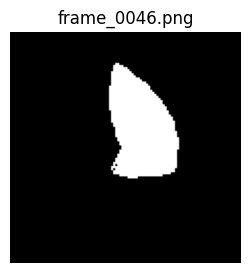

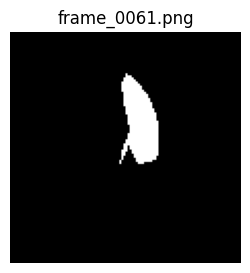

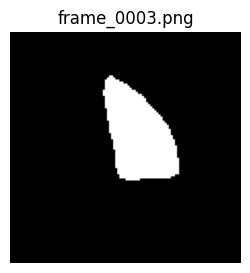

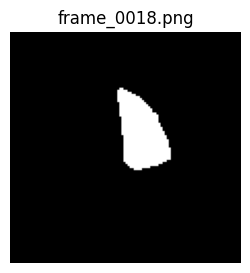

In [3]:
import glob
import matplotlib.pyplot as plt

NUMBER_MASK_PREVIEW = 4

paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT, "*", "frame_*.png")))[:NUMBER_MASK_PREVIEW]
for p in paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue\

    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap="gray", vmin=0, vmax=MASK_VALUE)
    plt.title(os.path.basename(p))
    plt.axis("off")
    plt.show()



## Below this is calculating andc comparing how well the masks were made, using the original expert tracings

In [4]:
import pandas as pd 

#load the pixel count data created from infering the masks from the expert volume tracings
pixel_count_df = pd.read_csv("pixel_count.csv")
pixel_count_df.head()

,FileName,Frame,PixelCount
0,0X100009310A3BD7FC.avi,46,1348
1,0X100009310A3BD7FC.avi,61,543
2,0X1002E8FBACD08477.avi,3,1225
3,0X1002E8FBACD08477.avi,18,680
4,0X1005D03EED19C65B.avi,24,842


In [13]:
#group by filename to find ESV/EDV using the min max args
pixel_extreme_vals = [] #create  a list of dictionaries for the new dataframe

#group by filename
for filename, group in pixel_count_df.groupby("FileName"):
    #get min and max index
    min_index = group["PixelCount"].idxmin() #get the ESV or lowest pix
    max_index = group["PixelCount"].idxmax() #get the EDV or highest pix
    
    # Get the actual rows for min/max
    min_row = group.loc[min_index]
    max_row = group.loc[max_index]
    
    # Simplified append
    pixel_extreme_vals.append({
        "Key": os.path.splitext(os.path.basename(filename))[0],
        "ESV_pixel": min_row["PixelCount"],
        "EDV_pixel": max_row["PixelCount"], 
        "ESV_frame": min_row["Frame"],
        "EDV_frame": max_row["Frame"]
    })

pixel_df = pd.DataFrame(pixel_extreme_vals)
print("Shape: " + str(pixel_df.shape))
print(pixel_df.head())

Shape: (10025, 5)
                  Key  ESV_pixel  EDV_pixel  ESV_frame  EDV_frame
0  0X100009310A3BD7FC        543       1348         61         46
1  0X1002E8FBACD08477        680       1225         18          3
2  0X1005D03EED19C65B        472        842         35         24
3  0X10075961BC11C88E        705       1109        108         91
4  0X10094BA0A028EAC3       1677       2070        156        137


In [18]:
#Load GT vals from FileList.csv 
filelist = filelist = pd.read_csv("FileList.csv")
print(filelist.head())

             FileName         EF         ESV         EDV  FrameHeight  \
0  0X100009310A3BD7FC  78.498406   14.881368   69.210534          112   
1  0X1002E8FBACD08477  59.101988   40.383876   98.742884          112   
2  0X1005D03EED19C65B  62.363798   14.267784   37.909734          112   
3  0X10075961BC11C88E  54.545097   33.143084   72.914210          112   
4  0X10094BA0A028EAC3  24.887742  127.581945  169.855024          112   

   FrameWidth  FPS  NumberOfFrames  
0         112   50             174  
1         112   50             215  
2         112   50             104  
3         112   55             122  
4         112   52             207  


In [19]:
#rename columns
filelist["Key"] = filelist["FileName"].astype(str).str.strip()
filelist = filelist.rename(columns={"EF": "EF_gt", "ESV": "ESV_gt", "EDV": "EDV_gt"})

In [24]:
#use left merge to merge on "Key"
merged_df = pixel_df.merge(filelist, on="Key", how="left")
'''Calculate the pixel based EF derived from the mask images using Simpsons method
((EDV - ESV)/EDV)*100'''
merged_df["EF_pixel"] = ((merged_df["EDV_pixel"] - merged_df["ESV_pixel"]) / merged_df["EDV_pixel"]) * 100 
'''Create a new column to calculate the difference between the pixel-derived EF vs the Ground Truth 
from expert tracings'''
merged_df["EF_error"] = merged_df["EF_pixel"] - merged_df["EF_gt"] 
print("Final DF Shape: " + str(merged_df.shape))
print(merged_df.head())

Final DF Shape: (10025, 15)
                  Key  ESV_pixel  EDV_pixel  ESV_frame  EDV_frame  \
0  0X100009310A3BD7FC        543       1348         61         46   
1  0X1002E8FBACD08477        680       1225         18          3   
2  0X1005D03EED19C65B        472        842         35         24   
3  0X10075961BC11C88E        705       1109        108         91   
4  0X10094BA0A028EAC3       1677       2070        156        137   

             FileName      EF_gt      ESV_gt      EDV_gt  FrameHeight  \
0  0X100009310A3BD7FC  78.498406   14.881368   69.210534        112.0   
1  0X1002E8FBACD08477  59.101988   40.383876   98.742884        112.0   
2  0X1005D03EED19C65B  62.363798   14.267784   37.909734        112.0   
3  0X10075961BC11C88E  54.545097   33.143084   72.914210        112.0   
4  0X10094BA0A028EAC3  24.887742  127.581945  169.855024        112.0   

   FrameWidth   FPS  NumberOfFrames   EF_pixel   EF_error  
0       112.0  50.0           174.0  59.718101 -18.780305 

In [27]:
''' Too much info on that merged_df, to make things nicer,
just pick the KEY, ESV/EDV/EF for the pixel and gt values'''
pixel_vs_gt_values = merged_df[["Key", "ESV_pixel", "EDV_pixel", "EF_pixel", "ESV_gt", "EDV_gt", "EF_gt", "EF_error"]].copy()
pixel_vs_gt_values.to_csv("pixel_vs_gt_values.csv", index=False)
print("Shape: " + str(pixel_vs_gt_values.shape))
print(pixel_vs_gt_values.head())

Shape: (10025, 8)
                  Key  ESV_pixel  EDV_pixel   EF_pixel      ESV_gt  \
0  0X100009310A3BD7FC        543       1348  59.718101   14.881368   
1  0X1002E8FBACD08477        680       1225  44.489796   40.383876   
2  0X1005D03EED19C65B        472        842  43.942993   14.267784   
3  0X10075961BC11C88E        705       1109  36.429216   33.143084   
4  0X10094BA0A028EAC3       1677       2070  18.985507  127.581945   

       EDV_gt      EF_gt   EF_error  
0   69.210534  78.498406 -18.780305  
1   98.742884  59.101988 -14.612192  
2   37.909734  62.363798 -18.420806  
3   72.914210  54.545097 -18.115881  
4  169.855024  24.887742  -5.902234  


In [28]:
'''Assess the EF error'''
import numpy as np
ef_error = pixel_vs_gt_values.copy()

ef_error["EF_error"]  = ef_error["EF_pixel"] - ef_error["EF_gt"]     # signed error (percentage points)
ef_error["abs_err"]    = ef_error["EF_error"].abs()
ef_error["sq_err"]     = ef_error["EF_error"]**2

summary = {
    "n":            len(ef_error),
    "bias_mean":    ef_error["EF_error"].mean(),                     # average over/underestimation
    "MAE":          ef_error["abs_err"].mean(),                       # mean absolute error (pp)
    "RMSE":         np.sqrt(ef_error["sq_err"].mean()),               # root mean square error (pp)
    "Pearson_r":    ef_error[["EF_gt","EF_pixel"]].corr().iloc[0,1]
}

pd.DataFrame([summary]).T.rename(columns={0: "value"}).round(3)

,value
n,10025.000
bias_mean,-17.174
MAE,17.174
RMSE,17.744
Pearson_r,0.945


## Past This is AI Generated correction: due to the mean bias of -17% EF which is clinically significant

In [4]:
# Add this new cell for bias-corrected mask creation

# ========================
# CREATE BIAS-CORRECTED MASKS
# ========================

import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt

print("Creating bias-corrected masks...")

# ==== ENHANCED CONFIG WITH BIAS CORRECTION ====
CSV_PATH = r"EchoNet-Dynamic/VolumeTracings.csv"
PIXEL_COUNT_OUTPUT_CORRECTED = "pixel_count_corrected.csv"
OUTPUT_ROOT_CORRECTED = "Outputs_BiasCorreted"  # New output directory
H, W = 112, 112
MASK_VALUE = 255

# BIAS CORRECTION SETTINGS
APPLY_MORPHOLOGICAL_CORRECTION = True
DILATION_KERNEL_SIZE = 3
DILATION_ITERATIONS = 2

print(f"Output directory: {OUTPUT_ROOT_CORRECTED}")
print(f"Morphological correction: {APPLY_MORPHOLOGICAL_CORRECTION}")
if APPLY_MORPHOLOGICAL_CORRECTION:
    print(f"Dilation: {DILATION_KERNEL_SIZE}x{DILATION_KERNEL_SIZE} kernel, {DILATION_ITERATIONS} iterations")

# Load the volume tracing CSV (reuse existing data)
volume_tracings = pd.read_csv(CSV_PATH)
x_cols = [c for c in volume_tracings.columns if c.upper().startswith("X")]
y_cols = [c for c in volume_tracings.columns if c.upper().startswith("Y")]

def sort_xy(cols, L):
    return sorted(cols, key=lambda c: int(c[len(L):]) if c[len(L):].isdigit() else 10**9)
x_cols, y_cols = sort_xy(x_cols, "X"), sort_xy(y_cols, "Y")

records_corrected = []
saved_corrected, skipped_corrected = 0, 0

print(f"\nProcessing {len(volume_tracings.groupby(['FileName', 'Frame']))} unique frame masks...")

# ENHANCED PROCESSING LOOP WITH BIAS CORRECTION
for (filename, frame), rows in volume_tracings.sort_values(["FileName","Frame"]).groupby(["FileName","Frame"]):
    x_coordinates = rows[x_cols].to_numpy(float).ravel() 
    y_coordinates = rows[y_cols].to_numpy(float).ravel()
    m = ~np.isnan(x_coordinates) & ~np.isnan(y_coordinates)
    endocardial_points = np.stack([x_coordinates[m], y_coordinates[m]], axis=1)
    
    if endocardial_points.shape[0] < 3: 
        skipped_corrected += 1
        continue

    # Process points (same as original)
    endocardial_points = np.unique(np.round(endocardial_points).astype(np.int32), axis=0)
    if endocardial_points.shape[0] < 3: 
        skipped_corrected += 1
        continue
        
    centroid = endocardial_points.mean(axis=0)
    ang = np.arctan2(endocardial_points[:,1]-centroid[1], endocardial_points[:,0]-centroid[0])
    endocardial_points = endocardial_points[np.argsort(ang)]
    endocardial_points[:,0] = np.clip(endocardial_points[:,0], 0, W-1)
    endocardial_points[:,1] = np.clip(endocardial_points[:,1], 0, H-1)

    # Create original mask
    mask = np.zeros((H, W), np.uint8)
    cv2.fillPoly(mask, [endocardial_points], MASK_VALUE)
    original_pixel_count = int(np.count_nonzero(mask))
    
    # APPLY BIAS CORRECTION - Morphological Enhancement
    if APPLY_MORPHOLOGICAL_CORRECTION:
        # Create dilation kernel
        kernel = np.ones((DILATION_KERNEL_SIZE, DILATION_KERNEL_SIZE), np.uint8)
        
        # Apply dilation to expand the mask
        mask_corrected = cv2.dilate(mask, kernel, iterations=DILATION_ITERATIONS)
        
        # Optional: Apply morphological closing to fill gaps
        # mask_corrected = cv2.morphologyEx(mask_corrected, cv2.MORPH_CLOSE, kernel)
    else:
        mask_corrected = mask.copy()
    
    corrected_pixel_count = int(np.count_nonzero(mask_corrected))
    pixel_increase = corrected_pixel_count - original_pixel_count
    percent_increase = (pixel_increase / original_pixel_count) * 100 if original_pixel_count > 0 else 0
    
    # Record both original and corrected pixel counts
    records_corrected.append({
        "FileName": filename, 
        "Frame": int(frame), 
        "PixelCount": corrected_pixel_count,
        "OriginalPixelCount": original_pixel_count,
        "PixelIncrease": pixel_increase,
        "PercentIncrease": percent_increase,
        "CorrectionMethod": "morphological_dilation",
        "KernelSize": DILATION_KERNEL_SIZE,
        "Iterations": DILATION_ITERATIONS
    })

    # Save corrected mask
    base = os.path.splitext(os.path.basename(filename))[0]
    out_dir = os.path.join(OUTPUT_ROOT_CORRECTED, base)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"frame_{int(frame):04d}.png")
    cv2.imwrite(out_path, mask_corrected)
    saved_corrected += 1

print(f"\n✅ BIAS CORRECTION COMPLETE")
print(f"Saved: {saved_corrected}, Skipped: {skipped_corrected}")

# Save corrected pixel data
out_df_corrected = pd.DataFrame.from_records(records_corrected).sort_values(["FileName","Frame"])
out_df_corrected.to_csv(PIXEL_COUNT_OUTPUT_CORRECTED, index=False)

print(f"📊 Written {len(out_df_corrected)} rows to {PIXEL_COUNT_OUTPUT_CORRECTED}")

# Show improvement statistics
avg_original = out_df_corrected['OriginalPixelCount'].mean()
avg_corrected = out_df_corrected['PixelCount'].mean()
avg_increase = out_df_corrected['PercentIncrease'].mean()

print(f"\n📈 PIXEL COUNT IMPROVEMENTS:")
print(f"   Average original pixels: {avg_original:.1f}")
print(f"   Average corrected pixels: {avg_corrected:.1f}")
print(f"   Average increase: +{avg_increase:.1f}%")
print(f"   Expected bias reduction: ~{avg_increase * 0.5:.1f} percentage points")

print(out_df_corrected.head())

Creating bias-corrected masks...
Output directory: Outputs_BiasCorreted
Morphological correction: True
Dilation: 3x3 kernel, 2 iterations

Processing 20050 unique frame masks...

✅ BIAS CORRECTION COMPLETE
Saved: 20050, Skipped: 0
📊 Written 20050 rows to pixel_count_corrected.csv

📈 PIXEL COUNT IMPROVEMENTS:
   Average original pixels: 1230.2
   Average corrected pixels: 1596.9
   Average increase: +33.5%
   Expected bias reduction: ~16.8 percentage points
                 FileName  Frame  PixelCount  OriginalPixelCount  \
0  0X100009310A3BD7FC.avi     46        1744                1348   
1  0X100009310A3BD7FC.avi     61         854                 543   
2  0X1002E8FBACD08477.avi      3        1593                1225   
3  0X1002E8FBACD08477.avi     18         960                 680   
4  0X1005D03EED19C65B.avi     24        1166                 842   

   PixelIncrease  PercentIncrease        CorrectionMethod  KernelSize  \
0            396        29.376855  morphological_dilation


VISUALIZING BIAS-CORRECTED MASKS
📁 Found 8 corrected mask files


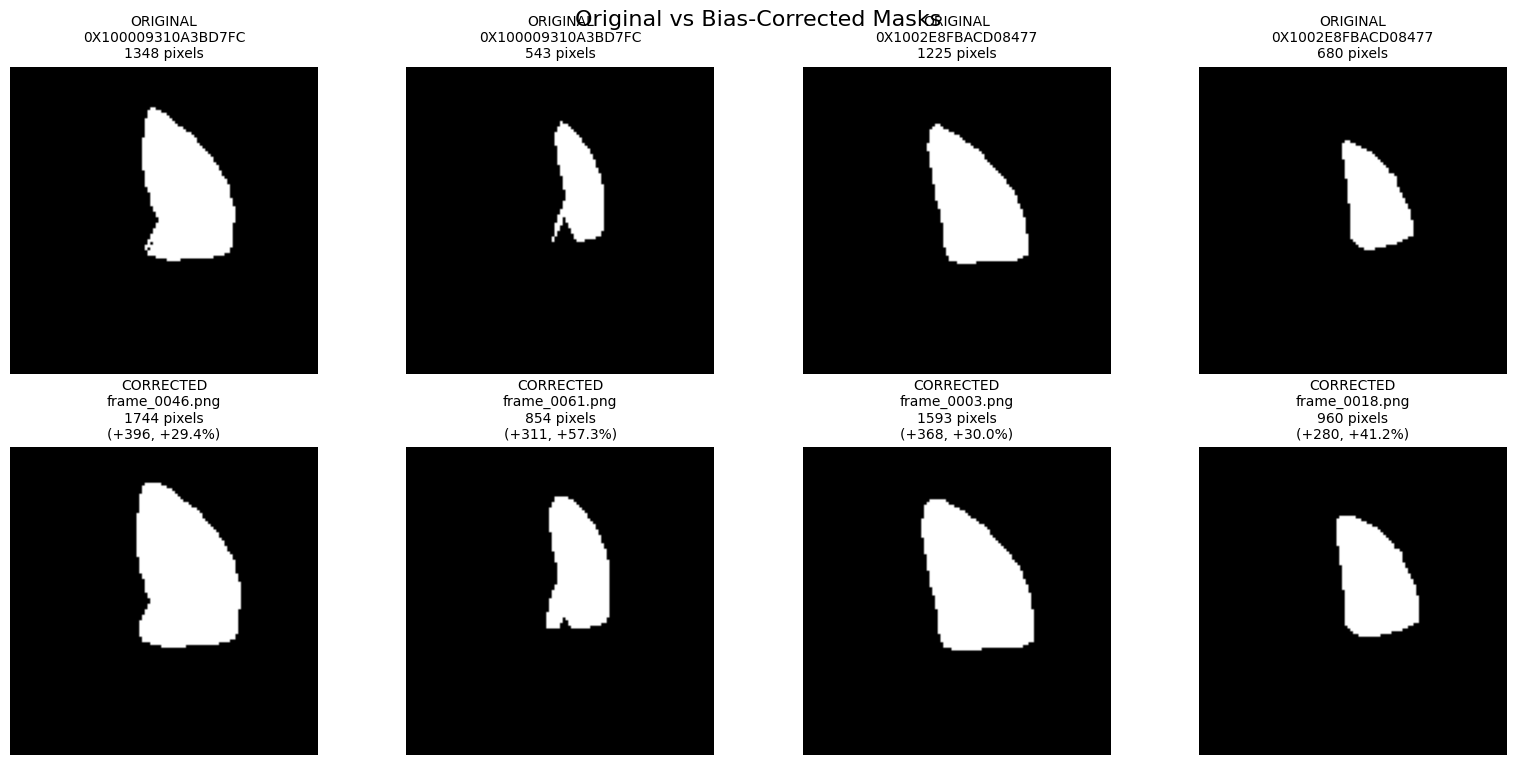

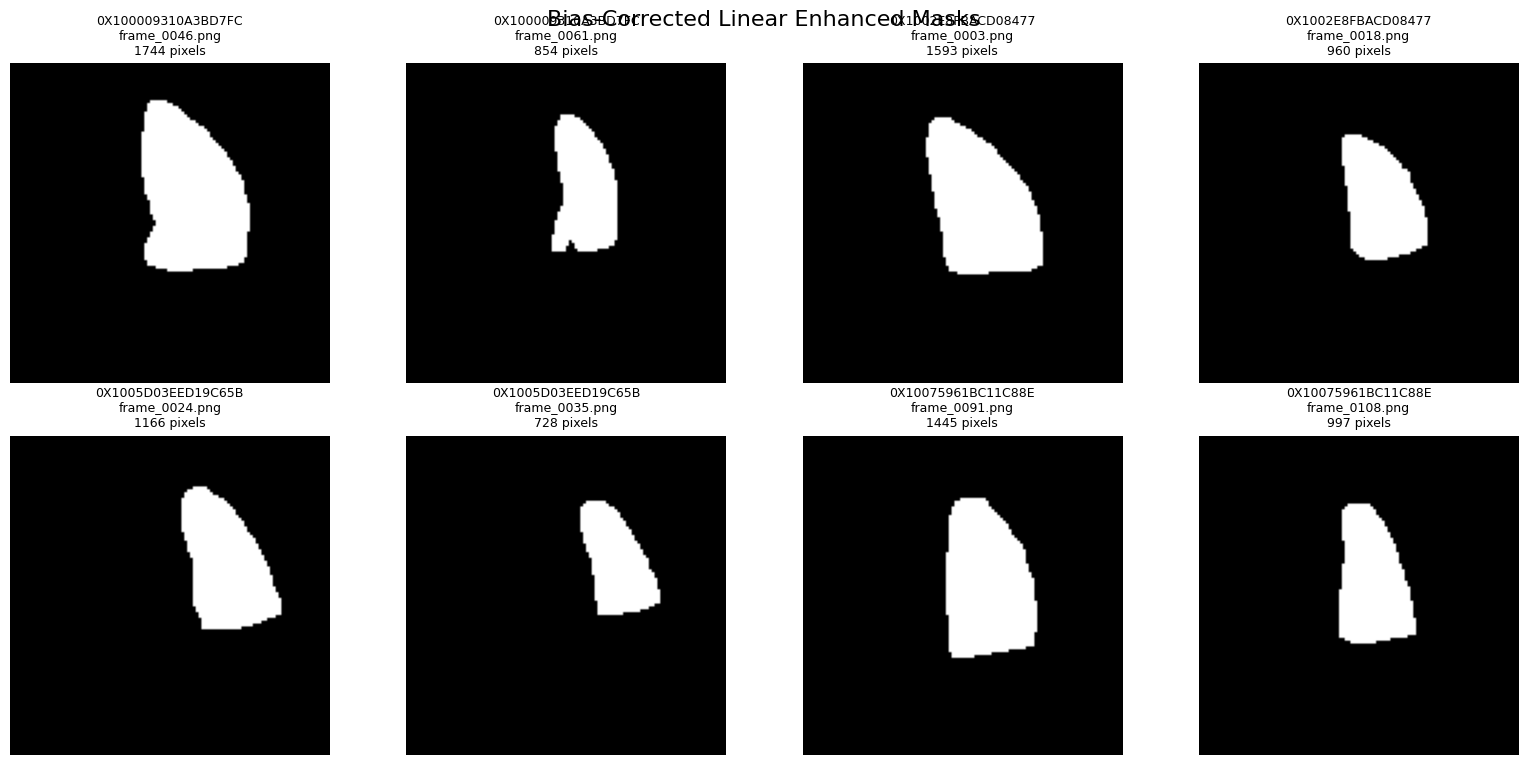

✅ Displayed 8 corrected masks


In [6]:
# Add this cell to visualize the corrected masks

# ========================
# VISUALIZE BIAS-CORRECTED MASKS
# ========================

import glob
import matplotlib.pyplot as plt

print("\n" + "="*50)
print("VISUALIZING BIAS-CORRECTED MASKS")
print("="*50)

OUTPUT_ROOT = "Outputs2"
NUMBER_MASK_PREVIEW = 8

# Get paths to corrected masks
corrected_paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT_CORRECTED, "*", "frame_*.png")))[:NUMBER_MASK_PREVIEW]
original_paths = sorted(glob.glob(os.path.join(OUTPUT_ROOT, "*", "frame_*.png")))[:NUMBER_MASK_PREVIEW]

if len(corrected_paths) == 0:
    print(f"❌ No corrected masks found in {OUTPUT_ROOT_CORRECTED}")
else:
    print(f"📁 Found {len(corrected_paths)} corrected mask files")
    
    # Create comparison grid: Original vs Corrected
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(min(4, len(corrected_paths))):
        # Load original and corrected masks
        if i < len(original_paths):
            orig_img = cv2.imread(original_paths[i], cv2.IMREAD_GRAYSCALE)
        else:
            orig_img = None
            
        corr_img = cv2.imread(corrected_paths[i], cv2.IMREAD_GRAYSCALE)
        
        # Extract file info
        video_name = os.path.basename(os.path.dirname(corrected_paths[i]))
        frame_name = os.path.basename(corrected_paths[i])
        
        # Top row: Original masks
        if orig_img is not None:
            orig_pixels = int(np.count_nonzero(orig_img))
            axes[0, i].imshow(orig_img, cmap="gray", vmin=0, vmax=MASK_VALUE)
            axes[0, i].set_title(f"ORIGINAL\n{video_name}\n{orig_pixels} pixels", fontsize=10)
        else:
            axes[0, i].text(0.5, 0.5, 'Original\nNot Found', ha='center', va='center')
            axes[0, i].set_title(f"ORIGINAL\n{video_name}\nN/A", fontsize=10)
        axes[0, i].axis("off")
        
        # Bottom row: Corrected masks
        if corr_img is not None:
            corr_pixels = int(np.count_nonzero(corr_img))
            axes[1, i].imshow(corr_img, cmap="gray", vmin=0, vmax=MASK_VALUE)
            
            # Calculate improvement
            if orig_img is not None:
                pixel_increase = corr_pixels - orig_pixels
                percent_increase = (pixel_increase / orig_pixels) * 100 if orig_pixels > 0 else 0
                axes[1, i].set_title(f"CORRECTED\n{frame_name}\n{corr_pixels} pixels\n(+{pixel_increase}, +{percent_increase:.1f}%)", fontsize=10)
            else:
                axes[1, i].set_title(f"CORRECTED\n{frame_name}\n{corr_pixels} pixels", fontsize=10)
        else:
            axes[1, i].text(0.5, 0.5, 'Failed to load', ha='center', va='center')
            axes[1, i].set_title("Error", fontsize=10)
        axes[1, i].axis("off")
    
    plt.suptitle("Original vs Bias-Corrected Masks", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

    # Show individual corrected masks in a grid
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, path in enumerate(corrected_paths):
        if i >= 8:
            break
            
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            video_name = os.path.basename(os.path.dirname(path))
            frame_name = os.path.basename(path)
            pixel_count = int(np.count_nonzero(img))
            
            axes[i].imshow(img, cmap="gray", vmin=0, vmax=MASK_VALUE)
            axes[i].set_title(f"{video_name}\n{frame_name}\n{pixel_count} pixels", fontsize=9)
        else:
            axes[i].text(0.5, 0.5, 'Failed to load', ha='center', va='center')
            axes[i].set_title("Error", fontsize=9)
        
        axes[i].axis("off")
    
    # Turn off unused subplots
    for i in range(len(corrected_paths), 8):
        axes[i].axis("off")
    
    plt.suptitle("Bias-Corrected Linear Enhanced Masks", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Displayed {min(8, len(corrected_paths))} corrected masks")